# Experiment1: Entropy Minimization

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt

### MNIST Data

In [33]:
# Load the labeled data from the .npz file
data = np.load('./Saved_Data/labeled_dataset_MNIST.npz')
labeled_images = data['images']
labled_labels = data['labels']

# Convert data to PyTorch tensors
labeled_images = torch.tensor(labeled_images, dtype=torch.float32)
labled_labels = torch.tensor(labled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
labeled_dataset = TensorDataset(labeled_images, labled_labels)
labeled_dataloaderMnist = DataLoader(labeled_dataset, batch_size=10, shuffle=True)

# Load the un-labeled data from the .npz file
data = np.load('./Saved_Data/unlabeled_dataset_MNIST.npz')
unlabeled_images = data['images']
unlabeled_labels = data['labels']

# Convert data to PyTorch tensors
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32)
unlabeled_labels = torch.tensor(unlabeled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
unlabeled_dataset = TensorDataset(unlabeled_images, unlabeled_labels)
unlabeled_dataloaderMnist = DataLoader(unlabeled_dataset, batch_size=50, shuffle=True)

In [34]:
class MnistNet(nn.Module):

    def __init__(self):

        super(MnistNet,self).__init__()
        self.flatten = nn.Flatten()
        self.fullyConnectedLayer = nn.Sequential(
            
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, input):
        
        input = self.flatten(input)
        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

In [35]:
#Create entropy loss for the unlabeled data 

def entropy_loss(logits):
    log_p = F.log_softmax(logits, dim=1)
    p = torch.exp(log_p)  # This is equivalent to softmax
    loss = -torch.sum(p * log_p, dim=1).mean()
    return loss

In [36]:
def calculate_accuracy(loader, model, dataMNIST = True):
    
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [37]:


# Training Function
def trainAndPlot(model, labeled_loader, unlabeled_loader, epochs=5, lr=0.001, alpha=0.1, readingAtEpoch = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store metrics
    supervised_losses = []
    unsupervised_losses = []
    train_accuracies = []
    test_accuracies = []

    # Variable to store the best test accuracy
    best_test_accuracy = 0.0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()


        for (labeled_data, labels), (unlabeled_data, _) in zip(labeled_loader, unlabeled_loader):
            # Forward pass for labeled data
            optimizer.zero_grad()
            
            outputs = model(labeled_data)
            loss = criterion(outputs, labels)

            # Forward pass for unlabeled data
            unlabeled_outputs = model(unlabeled_data)
            entropy_loss_unlabeled = entropy_loss(unlabeled_outputs)
            total_loss = loss + alpha * entropy_loss_unlabeled

            # Backward and optimize
            total_loss.backward()
            optimizer.step()

        if epoch%readingAtEpoch==0:

            supervised_loss_value = loss.item()
            unsupervised_loss_value = entropy_loss_unlabeled.item()
            train_accuracy_value = calculate_accuracy(labeled_loader, model)
            test_accuracy_value = calculate_accuracy(unlabeled_loader, model)


            if test_accuracy_value > best_test_accuracy:
                best_test_accuracy = test_accuracy_value
                best_epoch = epoch

            supervised_losses.append(supervised_loss_value)
            unsupervised_losses.append(unsupervised_loss_value)
            train_accuracies.append(train_accuracy_value)
            test_accuracies.append(test_accuracy_value)

            print(f"Epoch {epoch}: Supervised Loss: {supervised_loss_value}, "
                f"Unsupervised Loss: {unsupervised_loss_value}, "
                f"Training Accuracy: {train_accuracy_value}, "
                f"Testing Accuracy: {test_accuracy_value}")
            

    epochs = range(0, epochs, readingAtEpoch)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, supervised_losses, label='Supervised Training Loss')
    plt.plot(epochs, unsupervised_losses, label='Entropy Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Labeled Accuracy')
    plt.plot(epochs, test_accuracies, label='Unlabeled Accuracy')
    plt.scatter(best_epoch, best_test_accuracy, color='red')
    plt.text(best_epoch, best_test_accuracy, f'Best: {best_test_accuracy:.2f}% at Epoch {best_epoch}', 
             horizontalalignment='left', verticalalignment='bottom')
    plt.title('Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 0: Supervised Loss: 2.3050639629364014, Unsupervised Loss: 2.3023626804351807, Training Accuracy: 14.0, Testing Accuracy: 14.93939393939394
Epoch 10: Supervised Loss: 2.2181882858276367, Unsupervised Loss: 2.2997171878814697, Training Accuracy: 77.0, Testing Accuracy: 56.898989898989896
Epoch 20: Supervised Loss: 1.753668189048767, Unsupervised Loss: 2.2438385486602783, Training Accuracy: 85.0, Testing Accuracy: 61.323232323232325
Epoch 30: Supervised Loss: 1.3492196798324585, Unsupervised Loss: 1.986956000328064, Training Accuracy: 85.0, Testing Accuracy: 63.01010101010101
Epoch 40: Supervised Loss: 0.9649102091789246, Unsupervised Loss: 1.8413076400756836, Training Accuracy: 87.0, Testing Accuracy: 65.54545454545455
Epoch 50: Supervised Loss: 0.7607642412185669, Unsupervised Loss: 1.5446059703826904, Training Accuracy: 93.0, Testing Accuracy: 67.14141414141415
Epoch 60: Supervised Loss: 0.7670434713363647, Unsupervised Loss: 1.3289916515350342, Training Accuracy: 94.0, Testing 

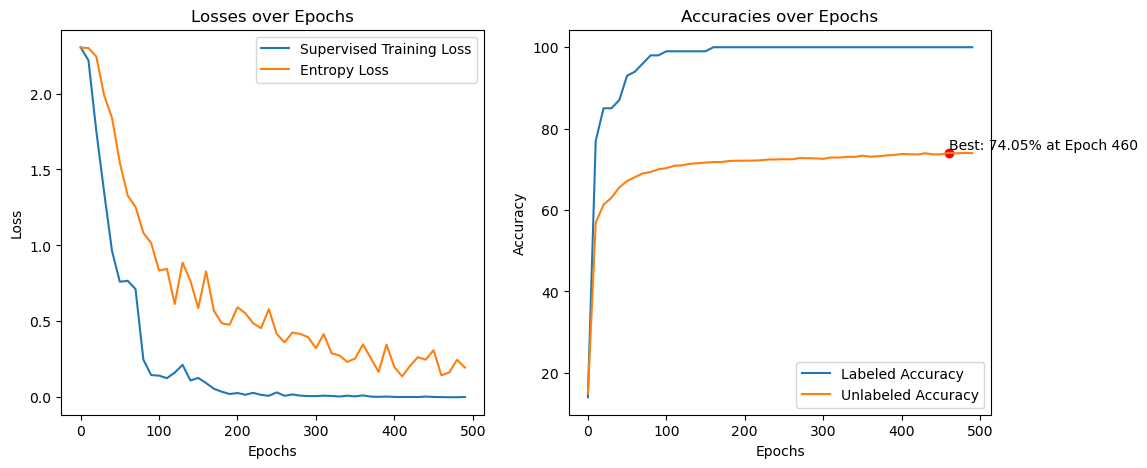

In [38]:

EntropyModel_MNIST = MnistNet()

trainAndPlot(model=EntropyModel_MNIST,
      labeled_loader=labeled_dataloaderMnist,
      unlabeled_loader=unlabeled_dataloaderMnist,
      epochs=500,
      lr = 0.002,
      alpha=0.1)

### Two Moons Dataset

In [51]:
selected_samples = np.load('./Saved_Data/labeled_dataset_TwoMoons.npy')

remaining_samples = np.load('./Saved_Data/unlabeled_dataset_TwoMoons.npy')

# Converting the selected samples and remaining samples into PyTorch tensors
selected_samples_tensor = torch.tensor(selected_samples, dtype=torch.float32)
remaining_samples_tensor = torch.tensor(remaining_samples, dtype=torch.float32)

# Extracting features and labels for both datasets
features_selected = selected_samples_tensor[:, :2]
labels_selected = selected_samples_tensor[:, 2].long()  # converting labels to long for classification

features_remaining = remaining_samples_tensor[:, :2]
labels_remaining = remaining_samples_tensor[:, 2].long()

# Creating TensorDatasets
selected_dataset = TensorDataset(features_selected, labels_selected)
remaining_dataset = TensorDataset(features_remaining, labels_remaining)

# Creating DataLoaders
labeled_dataloaderTM = DataLoader(selected_dataset, batch_size=1)  # small batch size for the small dataset
unlabeled_dataloaderTM = DataLoader(remaining_dataset, batch_size=5)  # larger batch size for the larger dataset

In [52]:
class TwoMoonsNet(nn.Module):

    def __init__(self):

        super(TwoMoonsNet,self).__init__()

        self.fullyConnectedLayer = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10,2)
        )

    def forward(self, input):

        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

Epoch 0: Supervised Loss: 0.5838229060173035, Unsupervised Loss: 0.687197208404541, Training Accuracy: 50.0, Testing Accuracy: 50.0
Epoch 2: Supervised Loss: 0.594664990901947, Unsupervised Loss: 0.6884282231330872, Training Accuracy: 50.0, Testing Accuracy: 50.0
Epoch 4: Supervised Loss: 0.6014465093612671, Unsupervised Loss: 0.6891471147537231, Training Accuracy: 50.0, Testing Accuracy: 50.0
Epoch 6: Supervised Loss: 0.6072059869766235, Unsupervised Loss: 0.6897139549255371, Training Accuracy: 50.0, Testing Accuracy: 48.96907216494845
Epoch 8: Supervised Loss: 0.6125068068504333, Unsupervised Loss: 0.6901939511299133, Training Accuracy: 50.0, Testing Accuracy: 46.90721649484536
Epoch 10: Supervised Loss: 0.617504894733429, Unsupervised Loss: 0.6906074285507202, Training Accuracy: 50.0, Testing Accuracy: 46.391752577319586
Epoch 12: Supervised Loss: 0.6222522854804993, Unsupervised Loss: 0.6909636855125427, Training Accuracy: 50.0, Testing Accuracy: 46.391752577319586
Epoch 14: Superv

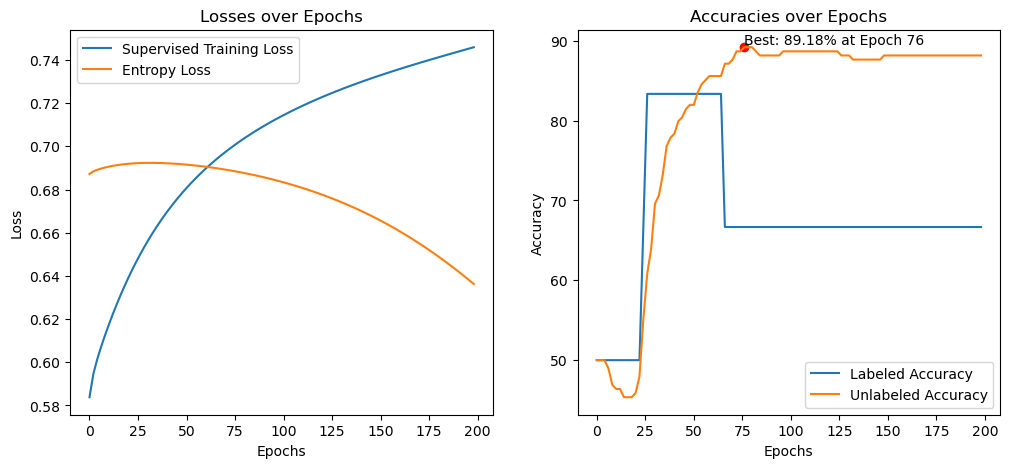

In [55]:
EntropyModel_TwoMoons = TwoMoonsNet()

trainAndPlot(model=EntropyModel_TwoMoons,
      labeled_loader=labeled_dataloaderTM,
      unlabeled_loader=unlabeled_dataloaderTM,
      epochs=200,
      lr = 0.001,
      alpha=0.1,
      readingAtEpoch=2)

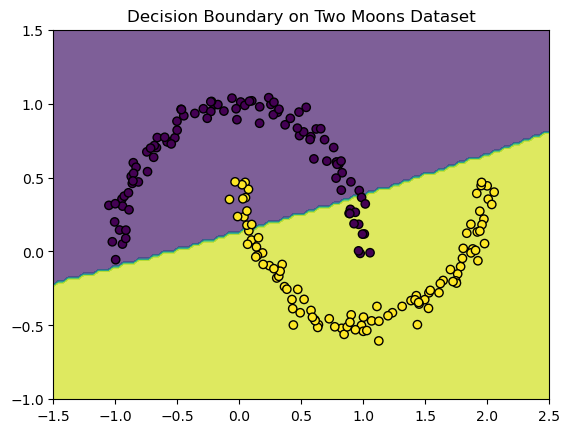

In [57]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

EntropyModel_TwoMoons.eval()
with torch.no_grad():
    predictions = EntropyModel_TwoMoons(grid_tensor)
    classes = torch.argmax(predictions, dim=1).numpy().reshape(xx.shape)

plt.contourf(xx, yy, classes, alpha=0.7)
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], c=selected_samples[:, 2], edgecolor='k')
plt.scatter(remaining_samples[:, 0], remaining_samples[:, 1], c=remaining_samples[:, 2], edgecolor='k')
plt.title("Decision Boundary on Two Moons Dataset")
plt.show()